### Applying Model Agnostic Interpretation to Ensemble Models

In [1]:
#!conda install -c conda-forge Skater --yes

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
# Reference for customizing matplotlib: https://matplotlib.org/users/style_sheets.html
plt.style.use('ggplot')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from skater.core.explanations import Interpretation
from skater.model import InMemoryModel


data = load_breast_cancer()
# Description of the data
print(data.DESCR)

pd.DataFrame(data.target_names)

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

,0
0,malignant
1,benign


### Lets build an Ensemble of heterogeneous Models

In [2]:
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
eclf = eclf.fit(X_train, y_train)

clf1 = clf1.fit(X_train, y_train)
clf2 = clf2.fit(X_train, y_train)
clf3 = clf3.fit(X_train, y_train)

models = {'lr':clf1, 
          'rf':clf2, 
          'gnb':clf3, 
          'ensemble':eclf}

### How can we interpret or explain an Ensemble Model ? 

#### Feature Importance:

2018-09-14 00:07:24,209 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[30/30] features ████████████████████ Time elapsed: 0 seconds

2018-09-14 00:07:24,865 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[30/30] features ████████████████████ Time elapsed: 0 seconds

2018-09-14 00:07:25,752 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[30/30] features ████████████████████ Time elapsed: 0 seconds

2018-09-14 00:07:26,368 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[30/30] features ████████████████████ Time elapsed: 0 seconds

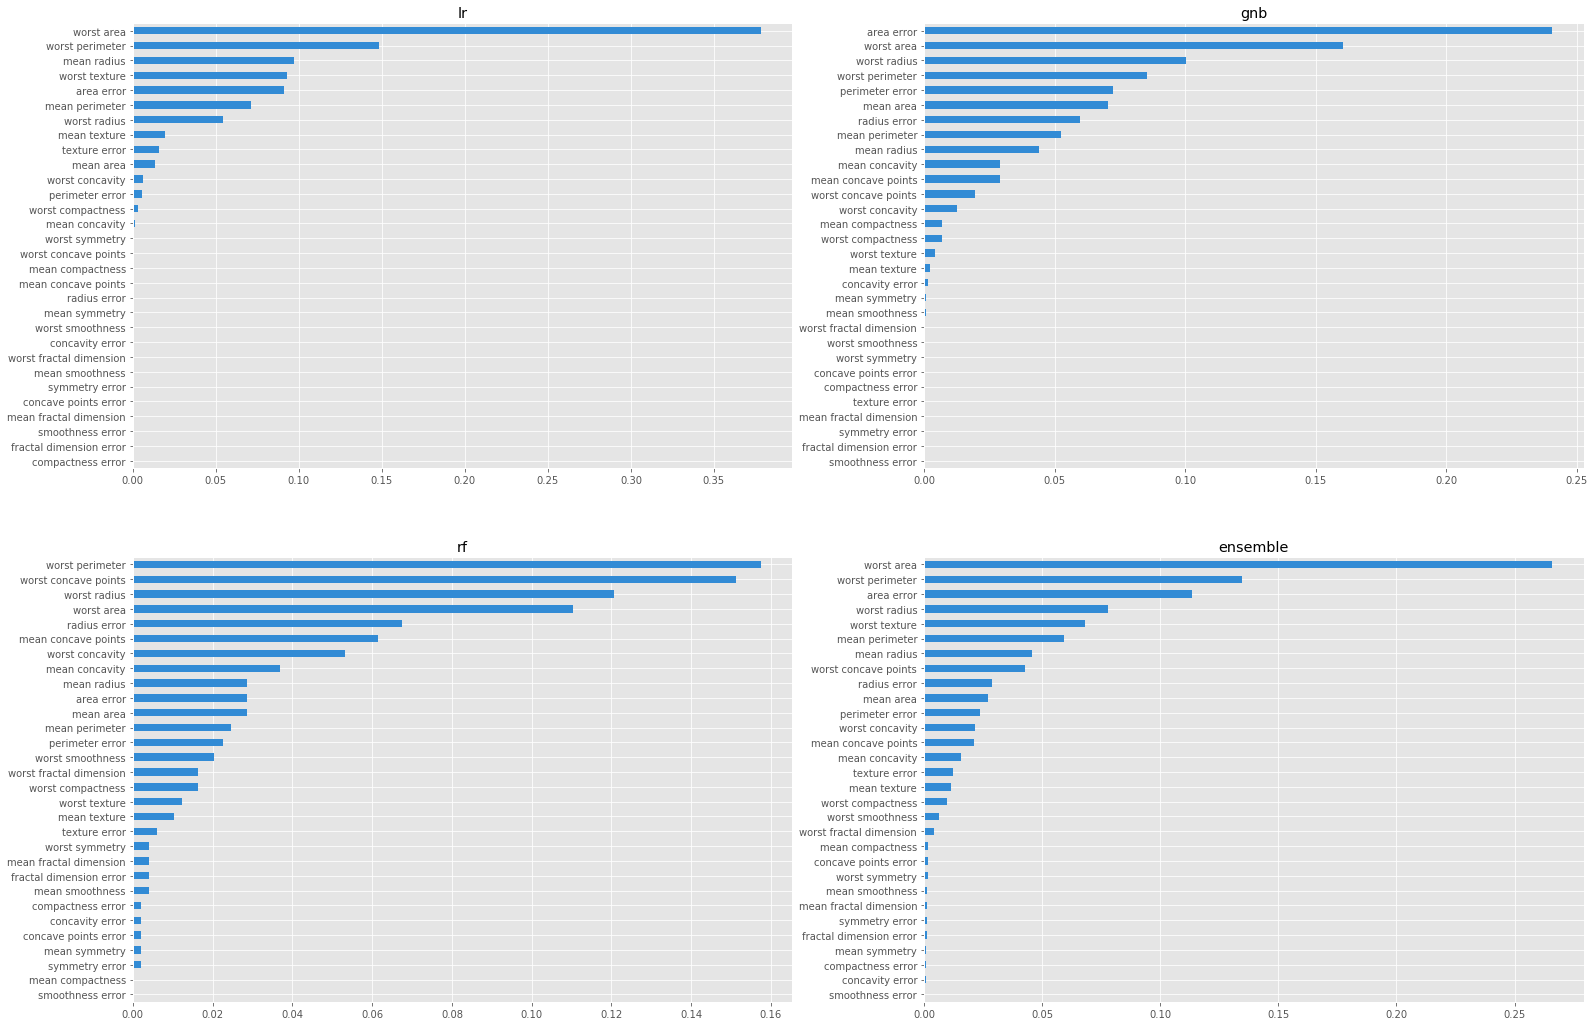

In [3]:
# Ensemble Classifier does not have feature importance enabled by default
f, axes = plt.subplots(2, 2, figsize = (26, 18))

ax_dict = {
    'lr':axes[0][0],
    'rf':axes[1][0],
    'gnb':axes[0][1],
    'ensemble':axes[1][1]
}

interpreter = Interpretation(X_test, feature_names=data.feature_names)

for model_key in models:
    pyint_model = InMemoryModel(models[model_key].predict_proba, examples=X_test)
    ax = ax_dict[model_key]
    interpreter.feature_importance.plot_feature_importance(pyint_model, ascending=True, ax=ax)
    ax.set_title(model_key)

In [4]:
# Before interpreting, lets check on the accuracy of all the models
from sklearn.metrics import f1_score
for model_key in models:
        print("Model Type: {0} -> F1 Score: {1}".
              format(model_key, f1_score(y_test, models[model_key].predict(X_test))))

Model Type: lr -> F1 Score: 0.9801324503311257
Model Type: rf -> F1 Score: 0.9743589743589742
Model Type: gnb -> F1 Score: 0.961038961038961
Model Type: ensemble -> F1 Score: 0.980891719745223


#### Decision Boundaries

In [5]:
%matplotlib inline
from skater.core.visualizer import decision_boundary as db
X_train = pd.DataFrame(X_train)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,11.20,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.000000,0.1060,0.05502,...,11.92,38.30,75.19,439.6,0.09267,0.05494,0.0000,0.00000,0.1566,0.05905
1,11.32,27.08,71.76,395.7,0.06883,0.03813,0.01633,0.003125,0.1869,0.05628,...,12.08,33.75,79.82,452.3,0.09203,0.14320,0.1089,0.02083,0.2849,0.07087
2,17.57,15.05,115.00,955.1,0.09847,0.11570,0.09875,0.079530,0.1739,0.06149,...,20.01,19.52,134.90,1227.0,0.12550,0.28120,0.2489,0.14560,0.2756,0.07919
3,11.71,16.67,74.72,423.6,0.10510,0.06095,0.03592,0.026000,0.1339,0.05945,...,13.33,25.48,86.16,546.7,0.12710,0.10280,0.1046,0.06968,0.1712,0.07343
4,13.87,20.70,89.77,584.8,0.09578,0.10180,0.03688,0.023690,0.1620,0.06688,...,15.05,24.75,99.17,688.6,0.12640,0.20370,0.1377,0.06845,0.2249,0.08492


In [12]:
# feature_list = interpreter.feature_names
# _, _ = db.plot_decision_boundary(eclf, X0=X_train.iloc[:, 0], X1=X_train.iloc[:, 1], 
#                                  feature_names=[feature_list[0], feature_list[1]],
#                                  Y=y_train, mode='interactive', height=6, width=10, file_name='iplot')

#### Partial Dependence Plots with Interactive slider for controlling grid resolution

In [7]:
def understanding_interaction():
    pyint_model = InMemoryModel(eclf.predict_proba, examples=X_test, target_names=data.target_names)
    # ['worst area', 'mean perimeter'] --> list(feature_selection.value)
    interpreter.partial_dependence.plot_partial_dependence(list(feature_selection.value),
                                                                    pyint_model, 
                                                                    grid_resolution=grid_resolution.value, 
                                                                    with_variance=True)
        
    # Lets understand interaction using 2-way interaction using the same covariates
    # feature_selection.value --> ('worst area', 'mean perimeter')
    axes_list = interpreter.partial_dependence.plot_partial_dependence([feature_selection.value],
                                                                       pyint_model, 
                                                                       grid_resolution=grid_resolution.value, 
                                                                       with_variance=True)

#### Understanding interaction using interactive widgets

In [8]:
#!conda install ipywidgets --yes
#!jupyter nbextension enable --py --sys-prefix widgetsnbextension

# One could further improve this by setting up an event callback using
# asynchronous widgets
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display
from IPython.display import clear_output
grid_resolution = widgets.IntSlider(description="GR", 
                                    value=10, min=10, max=100)
display(grid_resolution)

# dropdown to select relevant features from the dataset
feature_selection = widgets.SelectMultiple(
    options=tuple(data.feature_names),
    value=['worst area', 'mean perimeter'],
    description='Features',
    layout=widgets.Layout(display="flex", flex_flow='column', align_items = 'stretch'),
    disabled=False,
    multiple=True
)
display(feature_selection)

A Jupyter Widget

A Jupyter Widget

2018-09-14 00:07:51,926 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[10/10] grid cells ████████████████████ Time elapsed: 0 seconds

2018-09-14 00:07:52,730 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[10/10] grid cells ████████████████████ Time elapsed: 0 seconds

2018-09-14 00:07:53,467 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[100/100] grid cells ████████████████████ Time elapsed: 7 seconds

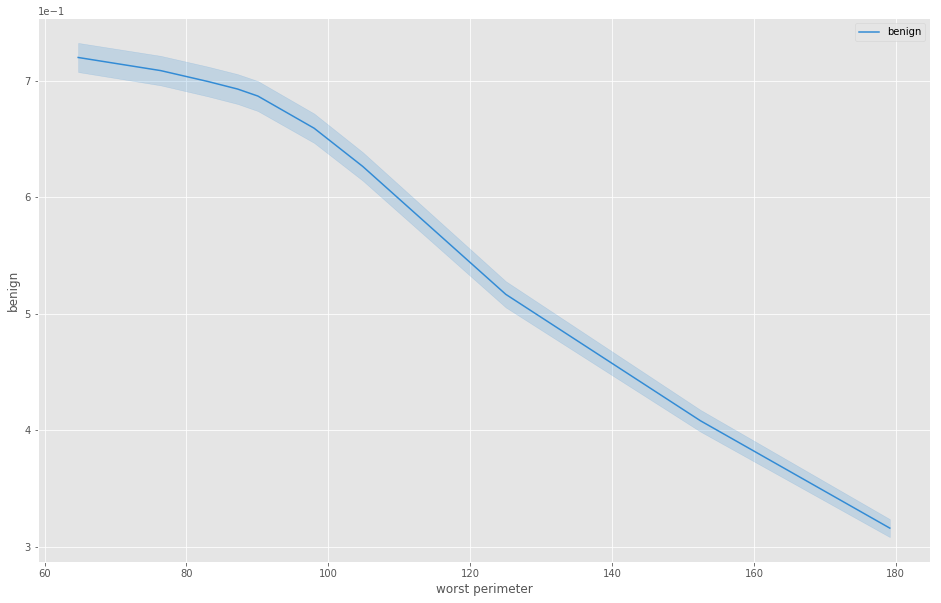

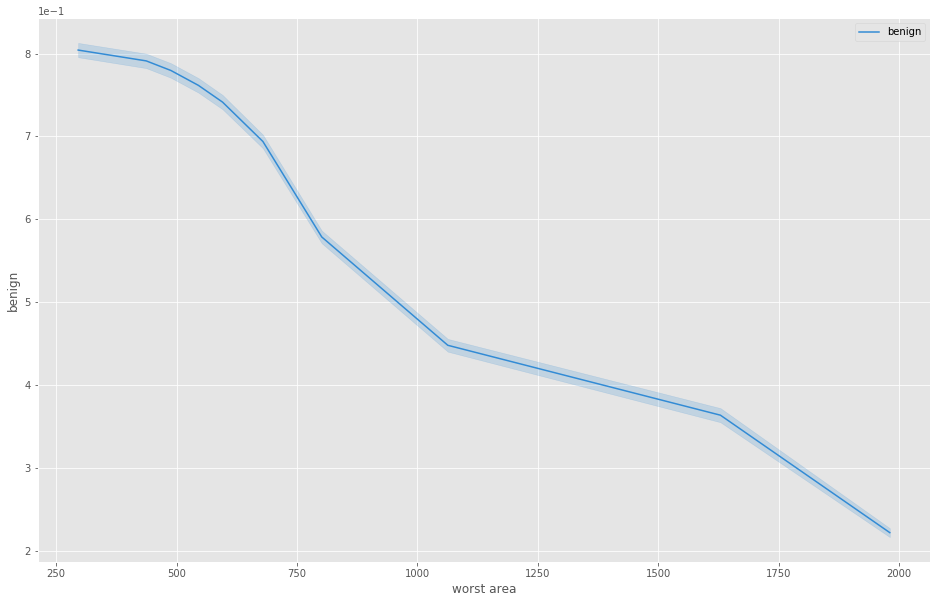

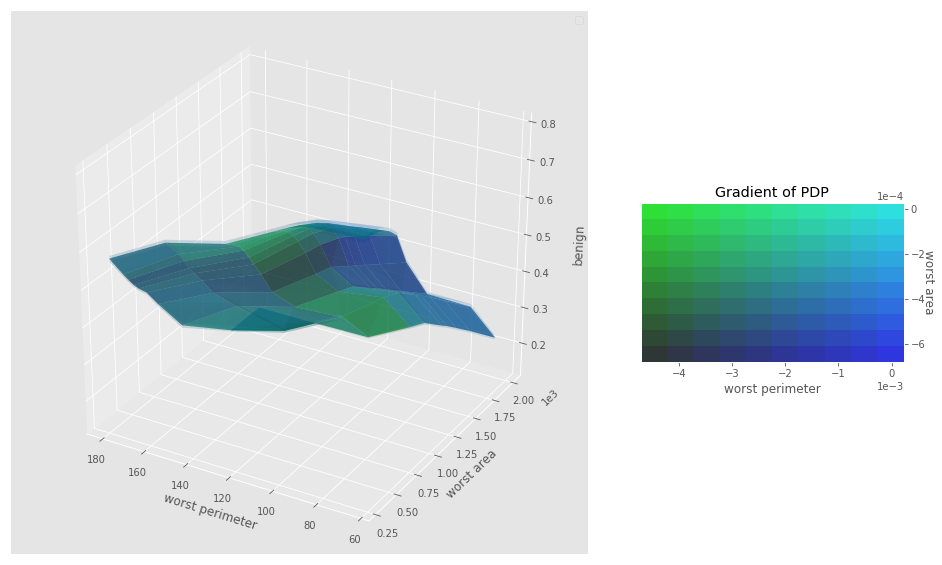

In [9]:
# Reference: http://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html
button = widgets.Button(description="Generate Interactions")
display(button)

def on_button_clicked(button_func_ref):
    clear_output()
    understanding_interaction()

button.on_click(on_button_clicked)

### To Evaluate a point locally, lets apply Local Interpretation using an interactive slider 

In [ ]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from IPython.display import display, HTML, clear_output
int_range = widgets.IntSlider(description="Index Selector", value=9, min=0, max=100)
display(int_range)

def on_value_change(change):
    index = change['new']
    exp = LimeTabularExplainer(X_test, 
                           feature_names=data.feature_names, 
                           discretize_continuous=False, 
                           class_names=['p(Cancer)-malignant', 'p(No Cancer)-benign'])
    print("Model behavior at row: {}".format(index))
    # Lets evaluate the prediction from the model and actual target label
    print("prediction from the model:{}".format(eclf.predict(X_test[index].reshape(1, -1))))
    print("Target Label on the row: {}".format(y_test.reshape(1,-1)[0][index]))
    clear_output()
    display(HTML(exp.explain_instance(X_test[index], models['ensemble'].predict_proba).as_html()))
    
int_range.observe(on_value_change, names='value')

## Conclusion:

Using global and local interpretation one is able to understand interactions between independent(input features) and dependent variable(P(Cancer)/P(No Cancer) by querying the model's behavior. 
While Feature Importance helped us in understanding more about the variable weights used by the predictive model. Partial dependence plots and LIME helped us understand interactions between the variables that is driving the prediction.